# Machine Learning: Assignment 1

In [1]:
import numpy as np
import pandas as pd
import time
import gc
import random
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import validation_curve
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from yellowbrick.model_selection import LearningCurve, ValidationCurve
from sklearn.preprocessing import OneHotEncoder
import time

#Random State
rs = 614

# 1. Data Import, leansing Setup and helper functions

In [2]:
class Data():
    def dataAllocation(self,path):
        df = pd.read_csv(path)
        print(df.shape)
        x_data = df.iloc[:, :-1]
        y_data = df.iloc[:, -1 ]
        return x_data,y_data
        # X, y = make_classification(n_samples=500, n_features=5, n_informative=5, n_redundant=0, random_state=rs)
        # return X, y

    def syntheticData(self):
        return make_classification(n_samples=2000, n_features=8, n_informative=8, n_redundant=0, random_state=rs)

    def trainSets(self,x_data,y_data):
        x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.3, random_state = rs, shuffle = True)
        return x_train, x_test, y_train, y_test

(768, 9)
Heatmap for Features


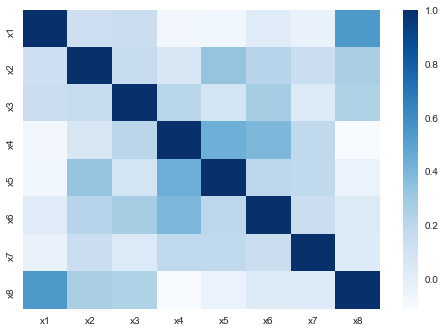

In [3]:

data = 'data/pima-indians-diabetes.csv'
dataset = Data()
x1_data,y1_data = dataset.dataAllocation(data)
x1_train, x1_test, y1_train, y1_test = dataset.trainSets(x1_data,y1_data)
scaler = StandardScaler()
scaled_x1_train = scaler.fit_transform(x1_train)
scaled_x1_test = scaler.transform(x1_test)

x2_data,y2_data = dataset.syntheticData()
x2_train, x2_test, y2_train, y2_test = dataset.trainSets(x2_data,y2_data)
scaler = StandardScaler()
scaled_x2_train = scaler.fit_transform(x2_train)
scaled_x2_test = scaler.transform(x2_test)

x_data = [x1_data, x2_data]
y_data = [y1_data, y2_data]
x_test = [x1_test, x2_test]
y_test = [y1_test, y2_test]
x_train = [x1_train, x2_train]
y_train = [y1_train, y2_train]
scaled_x_train = [scaled_x1_train, scaled_x2_train]
scaled_x_test = [scaled_x1_test, scaled_x2_test]


sizes = np.linspace(0.3, 1.0, 10)
print("Heatmap for Features")
data_corr = sns.heatmap(pd.DataFrame(x_data[0]).corr(), cmap='Blues')


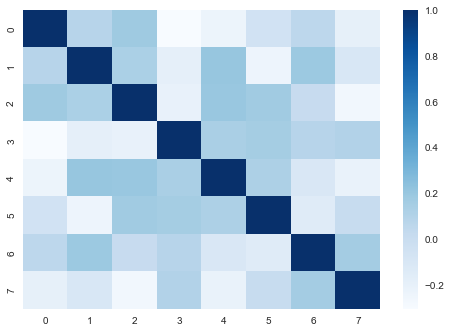

In [4]:
data_corr = sns.heatmap(pd.DataFrame(x_data[1]).corr(), cmap='Blues')

In [5]:
def fakeTunedData(i):
    fakeData = [{'max_depth': 9, 'min_samples_leaf': 1}, {'C': 0.01, 'kernel': 'linear'}, {'n_neighbors': 3}, {'hidden_layer_sizes': 81, 'learning_rate_init': 0.04},{'max_depth': 3, 'n_estimators': 90}]
    return 72+i, fakeData[i]

def learningCurvePlot(tuned, data_n):
    v1 = LearningCurve(tuned, scoring='f1_weighted', train_sizes=sizes, n_jobs=4)
    v1.fit(x_data[data_n],y_data[data_n])
    v1.show()

# 2. Decision Tree Classifier

In [6]:
class DTClassifier():

    def trainTest(self, data_n):
        df = []
        for i in range(20):
            dt_clf = DecisionTreeClassifier(max_depth=i+1, criterion='entropy', random_state=rs)
            dt_clf.fit(x_train[data_n], y_train[data_n])
            
            y1_predict_train = dt_clf.predict(x_train[data_n])
            y1_predict_test = dt_clf.predict(x_test[data_n])
            df.append([i+1, "Depth", "Train", f1_score(y_train[data_n], y1_predict_train)])
            df.append([i+1, "Depth", "Test", f1_score(y_test[data_n], y1_predict_test)])

        for i in range(20):
            dt_clf = DecisionTreeClassifier(min_samples_leaf=i+1, criterion='entropy', random_state=rs)
            dt_clf.fit(x_train[data_n], y_train[data_n])
            
            y1_predict_train = dt_clf.predict(x_train[data_n])
            y1_predict_test = dt_clf.predict(x_test[data_n])
            df.append([i+1, "Leaf Size", "Train", f1_score(y_train[data_n], y1_predict_train)])
            df.append([i+1, "Leaf Size", "Test", f1_score(y_test[data_n], y1_predict_test)])



        return pd.DataFrame(df, columns=["N", "Paramter Type", "Sample Type", "F1 Score" ])

    def hyperParameterTuning(self, data_n):
        param_grid = {'max_depth': range(1, 21), 'min_samples_leaf': range(1, 20)}
        tuned = GridSearchCV(estimator = DecisionTreeClassifier(random_state = rs), param_grid = param_grid, cv=10)
        
        start_time = time.time()
        tuned.fit(x_train[data_n], y_train[data_n])
        training_time = time.time() - start_time
        start_time = time.time()
        tuned.predict(x_test[data_n])
        testing_time = time.time() - start_time
        return tuned.best_score_, tuned.best_params_, training_time, testing_time

    def dataExplorePlot(self, df):
        g = sns.FacetGrid(df, hue="Sample Type", col="Paramter Type", height=2, col_wrap=4)
        g.map(sns.lineplot, "N", "F1 Score" )
    
    def showLearningCurve(self, best_params, data_n):
        tuned = DecisionTreeClassifier(max_depth=best_params['max_depth'], min_samples_leaf=best_params['min_samples_leaf'], random_state=rs)
        learningCurvePlot(tuned, data_n)        

# 3. Support Vector Machine

In [7]:
class SupportVectorMachine():
    def trainTest(self, data_n):
        cs = [x/10000 for x in [1, 10, 100, 1000, 10000, 100000, 1000000]]
        df = []
        for c in cs:
            for k in ["linear", "sigmoid"]:
                model = SVC(kernel = k, C=c)
                model.fit(scaled_x_train[data_n],y_train[data_n])
                y1_predict_train = model.predict(scaled_x_train[data_n])
                y1_predict_test = model.predict(scaled_x_test[data_n])
                df.append(["Train", k, c, accuracy_score(y_train[data_n], y1_predict_train)])
                df.append(["Test", k, c, accuracy_score(y_test[data_n], y1_predict_test)])
        return pd.DataFrame(df, columns=["Type", "Kernel", "C", "Accuracy"])
    
    def hyperParameterTuning(self, data_n):
        param_grid = {'C': [x/10000 for x in [1, 10, 100, 1000, 10000, 100000, 1000000]],  
            'kernel': ["linear", "sigmoid"]}  
        svm_tune = SVC(gamma = "auto")
        tuned = GridSearchCV(estimator = svm_tune, param_grid = param_grid, n_jobs=5, return_train_score=True)
        
        start_time = time.time()
        tuned.fit(scaled_x_train[data_n], y_train[data_n])
        training_time = time.time() - start_time
        start_time = time.time()
        tuned.predict(scaled_x_test[data_n])
        testing_time = time.time() - start_time
        return tuned.best_score_, tuned.best_params_, training_time, testing_time
        
    
    def dataExplorePlot(self, df):
        g = sns.FacetGrid(df, hue="Type", col="Kernel",  height=4)
        g.map(sns.pointplot, "C", "Accuracy")
        g.add_legend()
    
    def showLearningCurve(self, best_params, data_n):
        tuned = SVC(kernel=best_params['kernel'], C=best_params['C'])
        learningCurvePlot(tuned, data_n)
        

# 4. KNN

In [8]:
class KNN():
    def trainTest(self, data_n):
        df = []
        for i in range(20):
            model = KNeighborsClassifier(n_neighbors= i+1)
            model.fit(x_train[data_n], y_train[data_n])
            y1_predict_test = model.predict(x_test[data_n])
            y1_predict_train = model.predict(x_train[data_n])
            df.append(["Train", i+1, accuracy_score(y_train[data_n], y1_predict_train)])
            df.append(["Test", i+1, accuracy_score(y_test[data_n], y1_predict_test)])


        return pd.DataFrame(df, columns= ["Type", "Neighbors", "Accuracy"])
    
    def hyperParameterTuning(self, data_n):
        tuned = GridSearchCV(KNeighborsClassifier(), {"n_neighbors" : range(1, 21)})
        
        start_time = time.time()
        tuned.fit(x_train[data_n], y_train[data_n])
        training_time = time.time() - start_time
        start_time = time.time()
        tuned.predict(x_test[data_n])
        testing_time = time.time() - start_time
        return tuned.best_score_, tuned.best_params_, training_time, testing_time

    def dataExplorePlot(self, df):
        sns.lineplot(data=df, x="Neighbors", y="Accuracy", hue="Type")
    
    def showLearningCurve(self, best_params, data_n):
        tuned = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'])
        learningCurvePlot(tuned, data_n)


# 5. Neural Network

In [9]:
class NN():

    def trainTest(self, data_n):
        df = []
        for i in [x/100000 for x in [1, 10, 100, 1000, 10000, 100000]]:
            model = MLPClassifier(max_iter=300, learning_rate_init=i)
            model.fit(scaled_x_train[data_n],y_train[data_n])
            y1_predict_train = model.predict(scaled_x_train[data_n])
            y1_predict_test = model.predict(scaled_x_test[data_n])
            df.append(["Train", "learning_rate_init", i, accuracy_score(y_train[data_n], y1_predict_train)])
            df.append(["Test", "learning_rate_init", i, accuracy_score(y_test[data_n], y1_predict_test)])
        
        for i in [x**2 for x in range(2, 11)]:
            model = MLPClassifier(max_iter=300, hidden_layer_sizes=i)
            model.fit(scaled_x_train[data_n],y_train[data_n])
            y1_predict_train = model.predict(scaled_x_train[data_n])
            y1_predict_test = model.predict(scaled_x_test[data_n])
            df.append(["Test", "hidden_layer_sizes", i, accuracy_score(y_test[data_n], y1_predict_test)])
            df.append(["Train", "hidden_layer_sizes", i, accuracy_score(y_train[data_n], y1_predict_train)])

        return pd.DataFrame(df, columns=["Sample Type", "Paramter Type", "X", "Accuracy"])
        
    def hyperParameterTuning(self, data_n):
        param_grid = {
            'hidden_layer_sizes': [x**2 for x in range(2, 11)],
            'learning_rate_init': [x/100000 for x in [1, 10, 100, 1000, 10000, 100000]]
        }
        tuned = GridSearchCV(MLPClassifier(max_iter=200), param_grid = param_grid, cv=10)
        
        start_time = time.time()
        tuned.fit(scaled_x_train[data_n], y_train[data_n])
        training_time = time.time() - start_time
        start_time = time.time()
        tuned.predict(scaled_x_test[data_n])
        testing_time = time.time() - start_time
        return tuned.best_score_, tuned.best_params_, training_time, testing_time

    def dataExplorePlot(self, df):
        sns.pointplot(data=df[df["Paramter Type"] == "learning_rate_init"], x="X", y="Accuracy", hue="Sample Type" )
        plt.figure()
        sns.pointplot(data=df[df["Paramter Type"] == "hidden_layer_sizes"], x="X", y="Accuracy", hue="Sample Type" )
        
        
    def showLearningCurve(self, best_params, data_n):
        tuned = MLPClassifier(max_iter=50, learning_rate_init=best_params['learning_rate_init'], hidden_layer_sizes=best_params['hidden_layer_sizes'])
        learningCurvePlot(tuned, data_n)
        

# 6. Boost

In [10]:
class Boost():
    def trainTest(self, data_n):
        df = []
        for i in range(1, 251, 10):
            model = GradientBoostingClassifier(n_estimators=i, max_depth=3, min_samples_leaf=10)
            model.fit(scaled_x_train[data_n],y_train[data_n])
            y1_predict_train = model.predict(scaled_x_train[data_n])
            y1_predict_test = model.predict(scaled_x_test[data_n])
            df.append(["Train", i, accuracy_score(y_train[data_n], y1_predict_train)])
            df.append(["Test", i, accuracy_score(y_test[data_n], y1_predict_test)])
        return pd.DataFrame(df, columns=["Sample Type", "Estimators", "Accuracy"])
        
    def hyperParameterTuning(self, data_n):
        param_grid = {'n_estimators': range(1, 251, 10)}
        tuned = GridSearchCV(GradientBoostingClassifier(max_depth=3, min_samples_leaf=10), param_grid, cv=10)
        
        start_time = time.time()
        tuned.fit(scaled_x_train[data_n], y_train[data_n])
        training_time = time.time() - start_time
        start_time = time.time()
        tuned.predict(scaled_x_test[data_n])
        testing_time = time.time() - start_time
        return tuned.best_score_, tuned.best_params_, training_time, testing_time
    
    def dataExplorePlot(self, df):
        sns.lineplot(data=df, x="Estimators", y="Accuracy", hue="Sample Type")

    def showLearningCurve(self, best_params, data_n):
        tuned = GradientBoostingClassifier(n_estimators=best_params['n_estimators'], max_depth=3, min_samples_leaf=10)
        learningCurvePlot(tuned, data_n)
    

1. Decision Tree

1.1 Hyperparameters Exploration

For this project, Decision Tree will be hypertuned by adjusting: ['max_depth', 'min_samples_leaf']. The following charts show how the accuracy is affected when the hyperparamter(s) are changed for both dataset 1 and dataset 2:



1.2 Hypertuning

GridSearchCV was performed for Decision Tree classifier.

Dataset 1 Results:
The optimal value of max_depth was 6. The optimal value of min_samples_leaf was 17. Likewise the accuracy of Decision Tree classifier was 0.7635918937805731 when the optimized hyperparameter(s) value(s) were used.


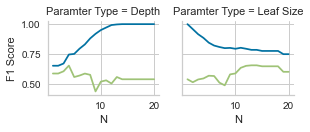

<Figure size 576x396 with 0 Axes>

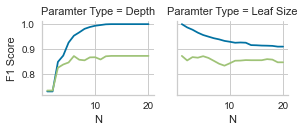

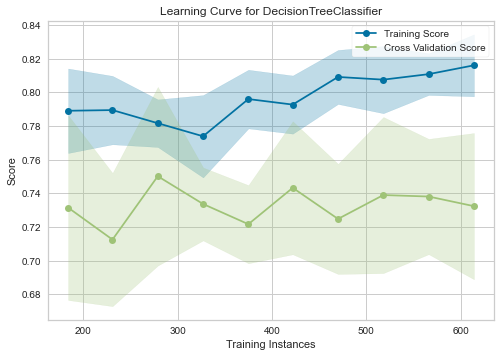

Dataset 2 Results:
The optimal value of max_depth was 10. The optimal value of min_samples_leaf was 3. Likewise the accuracy of Decision Tree classifier was 0.8764285714285714 when the optimized hyperparameter(s) value(s) were used.


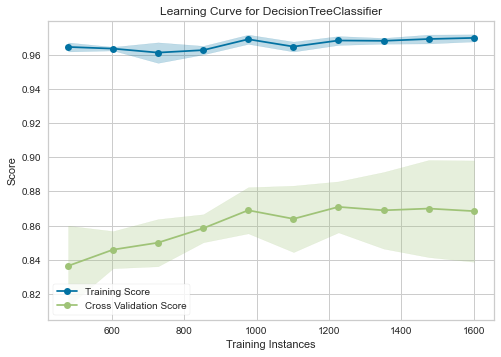



2. Support Vector Machine

2.1 Hyperparameters Exploration

For this project, Support Vector Machine will be hypertuned by adjusting: ['C', 'kernel']. The following charts show how the accuracy is affected when the hyperparamter(s) are changed for both dataset 1 and dataset 2:



2.2 Hypertuning

GridSearchCV was performed for Support Vector Machine classifier.

Dataset 1 Results:
The optimal value of C was 1.0. The optimal value of kernel was linear. Likewise the accuracy of Support Vector Machine classifier was 0.7820526133610246 when the optimized hyperparameter(s) value(s) were used.


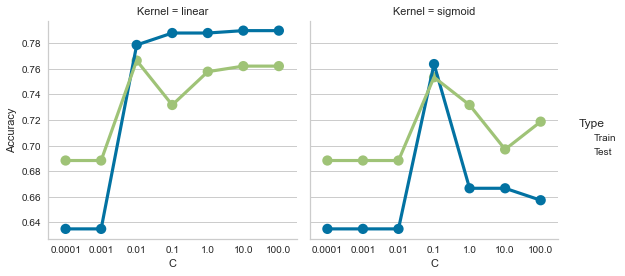

<Figure size 576x396 with 0 Axes>

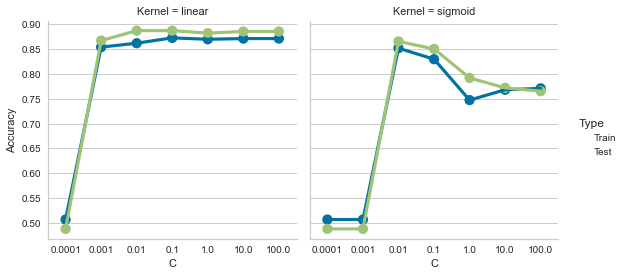

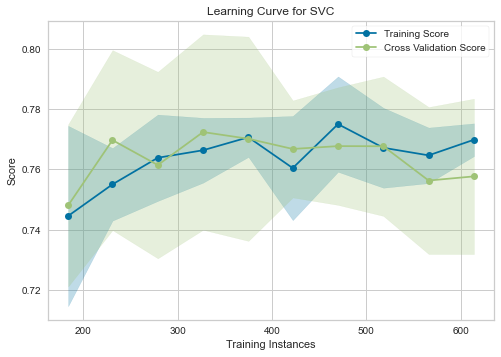

Dataset 2 Results:
The optimal value of C was 100.0. The optimal value of kernel was linear. Likewise the accuracy of Support Vector Machine classifier was 0.8635714285714287 when the optimized hyperparameter(s) value(s) were used.


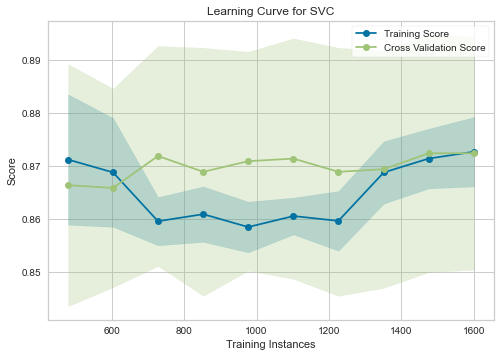



3. K-Nearest Neighbors

3.1 Hyperparameters Exploration

For this project, K-Nearest Neighbors will be hypertuned by adjusting: ['n_neighbors']. The following charts show how the accuracy is affected when the hyperparamter(s) are changed for both dataset 1 and dataset 2:



3.2 Hypertuning

GridSearchCV was performed for K-Nearest Neighbors classifier.

Dataset 1 Results:
The optimal value of n_neighbors was 12. Likewise the accuracy of K-Nearest Neighbors classifier was 0.7690377293181032 when the optimized hyperparameter(s) value(s) were used.


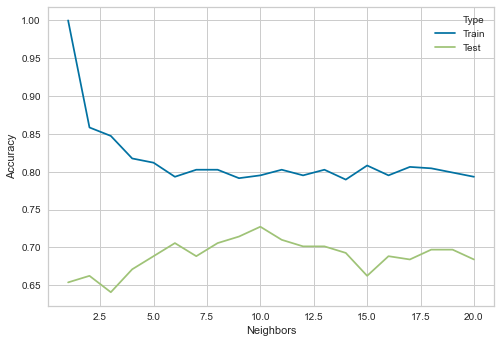

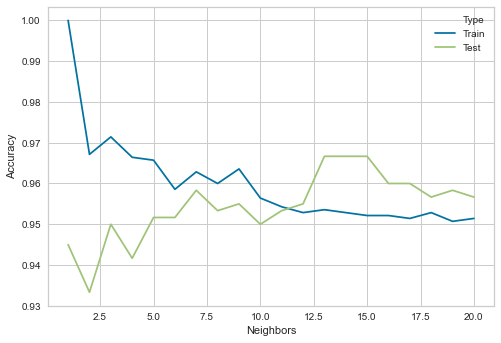

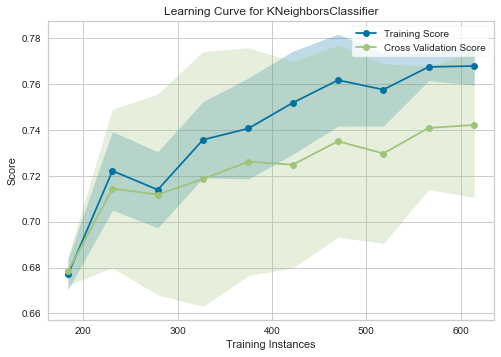

Dataset 2 Results:
The optimal value of n_neighbors was 11. Likewise the accuracy of K-Nearest Neighbors classifier was 0.9464285714285714 when the optimized hyperparameter(s) value(s) were used.


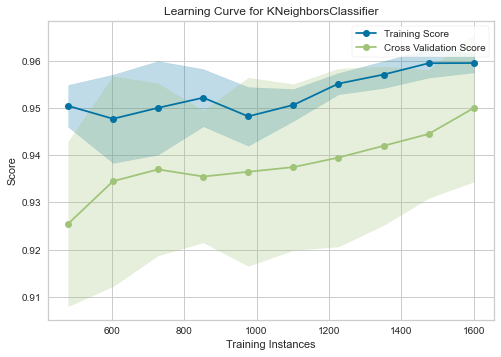



4. Neural Network

4.1 Hyperparameters Exploration

For this project, Neural Network will be hypertuned by adjusting: ['hidden_layer_sizes', 'learning_rate_init']. The following charts show how the accuracy is affected when the hyperparamter(s) are changed for both dataset 1 and dataset 2:



4.2 Hypertuning

GridSearchCV was performed for Neural Network classifier.

Dataset 1 Results:
The optimal value of hidden_layer_sizes was 25. The optimal value of learning_rate_init was 0.001. Likewise the accuracy of Neural Network classifier was 0.7841719077568134 when the optimized hyperparameter(s) value(s) were used.


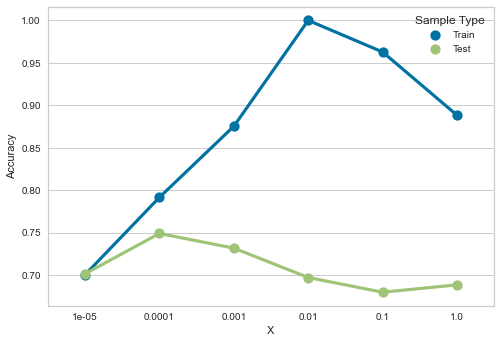

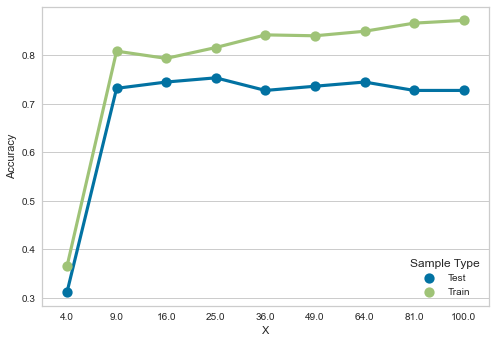

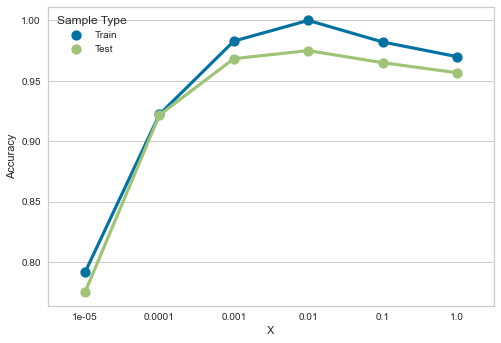

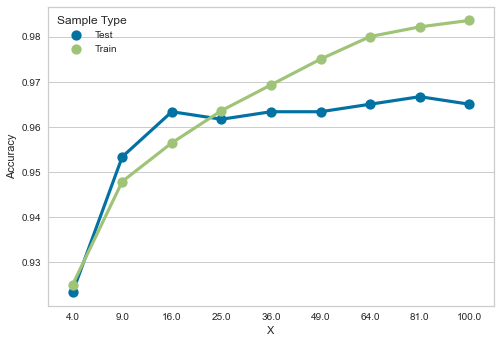

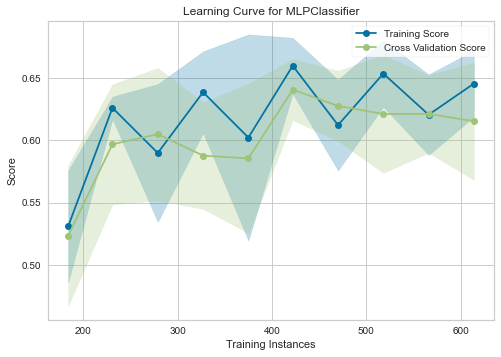

Dataset 2 Results:
The optimal value of hidden_layer_sizes was 100. The optimal value of learning_rate_init was 0.01. Likewise the accuracy of Neural Network classifier was 0.9614285714285714 when the optimized hyperparameter(s) value(s) were used.


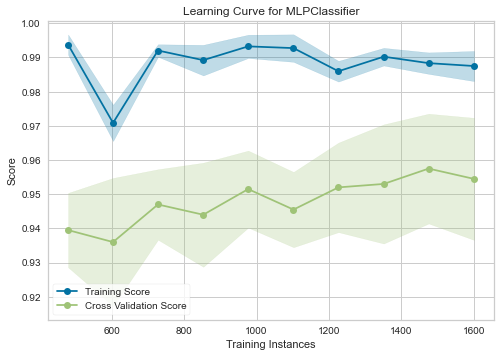



5. Gradient Boosting

5.1 Hyperparameters Exploration

For this project, Gradient Boosting will be hypertuned by adjusting: ['n_estimators']. The following charts show how the accuracy is affected when the hyperparamter(s) are changed for both dataset 1 and dataset 2:



5.2 Hypertuning

GridSearchCV was performed for Gradient Boosting classifier.

Dataset 1 Results:
The optimal value of n_estimators was 51. Likewise the accuracy of Gradient Boosting classifier was 0.7784765897973445 when the optimized hyperparameter(s) value(s) were used.


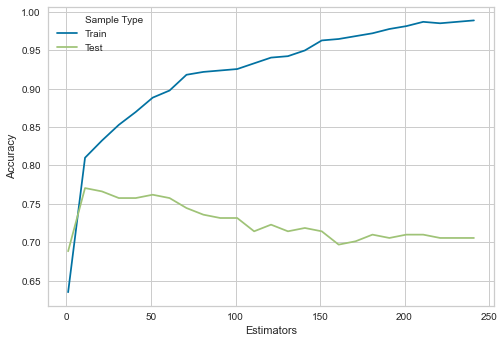

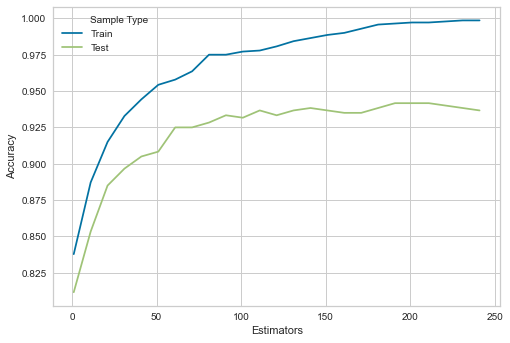

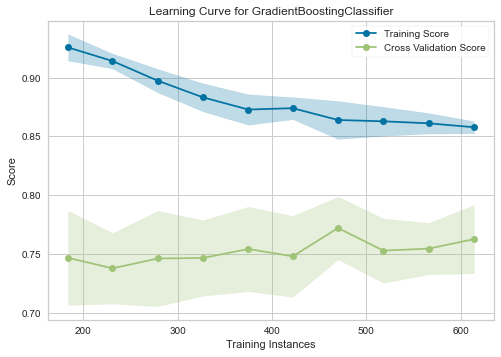

Dataset 2 Results:
The optimal value of n_estimators was 241. Likewise the accuracy of Gradient Boosting classifier was 0.927142857142857 when the optimized hyperparameter(s) value(s) were used.


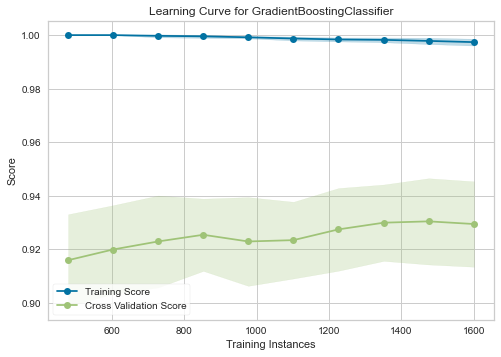

In [11]:
classifiers = [DTClassifier(), SupportVectorMachine(), KNN(), NN(), Boost()]
#classifiers = [KNN()]

classifiers_name = ["Decision Tree", "Support Vector Machine", "K-Nearest Neighbors", "Neural Network", "Gradient Boosting"]

i = 0

accuracies = []
train_times = []
test_times = []

for classifier in classifiers:
    name = classifiers_name[i]
    print(str(i+1)+".", name, end="\n\n")
    df1 = classifier.trainTest(0)
    df2 = classifier.trainTest(1)
    classifier.dataExplorePlot(df1)
    plt.figure()
    classifier.dataExplorePlot(df2)
    plt.figure()

    #best_score, best_params = fakeTunedData(i)
    best_score1, best_params1, training_time1, testing_time1 = classifier.hyperParameterTuning(0)
    best_score2, best_params2, training_time2, testing_time2 = classifier.hyperParameterTuning(1)
    accuracies.append(["Dataset 1", best_score1])
    accuracies.append(["Dataset 2", best_score2])
    train_times.append(["Dataset 1", training_time1])
    train_times.append(["Dataset 2", training_time2])
    test_times.append(["Dataset 1", testing_time1])
    test_times.append(["Dataset 2", testing_time2])
    print(str(i+1)+".1","Hyperparameters Exploration", end="\n\n")
    print("For this project,", name, "will be hypertuned by adjusting:", [x for x in best_params1], end=". ")
    print("The following charts show how the accuracy is affected when the hyperparamter(s) are changed for both dataset 1 and dataset 2:")
    
    print("\n\n")
    print(str(i+1)+".2","Hypertuning", end="\n\n")
    print("GridSearchCV was performed for", name, "classifier." , end="\n\n")
    print("Dataset 1 Results:")
    for key in best_params1:
        print("The optimal value of", key, "was", best_params1[key], end = ". ")
    print("Likewise the accuracy of", name, "classifier", "was", best_score1, "when the optimized hyperparameter(s) value(s) were used.")
    classifier.showLearningCurve(best_params1, 0)
    
    print("Dataset 2 Results:")
    for key in best_params2:
        print("The optimal value of", key, "was", best_params2[key], end = ". ")
    print("Likewise the accuracy of", name, "classifier", "was", best_score2, "when the optimized hyperparameter(s) value(s) were used.")
    classifier.showLearningCurve(best_params2, 1)
    print()
    print()

    i = i + 1


In [12]:
train_times

[['Dataset 1', 12.758336067199707],
 ['Dataset 2', 18.173854112625122],
 ['Dataset 1', 1.5860681533813477],
 ['Dataset 2', 2.237246036529541],
 ['Dataset 1', 0.6618459224700928],
 ['Dataset 2', 1.1341099739074707],
 ['Dataset 1', 119.77273082733154],
 ['Dataset 2', 290.4396331310272],
 ['Dataset 1', 45.655099868774414],
 ['Dataset 2', 116.97686910629272]]

In [23]:
df_accuracy = pd.DataFrame(accuracies, columns=["Dataset", "Accuracy %"])
df_train_time = pd.DataFrame(train_times, columns=["Dataset", "Time (s)"])
df_test_time = pd.DataFrame(test_times, columns=["Dataset", "Time (s)"])

In [24]:
df_accuracy.head()

,Dataset,Accuracy %
0,Dataset 1,0.763592
1,Dataset 2,0.876429
2,Dataset 1,0.782053
3,Dataset 2,0.863571
4,Dataset 1,0.769038


In [25]:
names = ["Decision Tree", "Decision Tree","Support Vector Machine", "Support Vector Machine", "K-Nearest Neighbors", "K-Nearest Neighbors", "Neural Network", "Neural Network", "Gradient Boosting", "Gradient Boosting"]

In [26]:
df_accuracy['Classifier'] = names
df_train_time['Classifier'] = names
df_test_time['Classifier'] = names

In [27]:
df_accuracy.head()

,Dataset,Accuracy %,Classifier
0,Dataset 1,0.763592,Decision Tree
1,Dataset 2,0.876429,Decision Tree
2,Dataset 1,0.782053,Support Vector Machine
3,Dataset 2,0.863571,Support Vector Machine
4,Dataset 1,0.769038,K-Nearest Neighbors


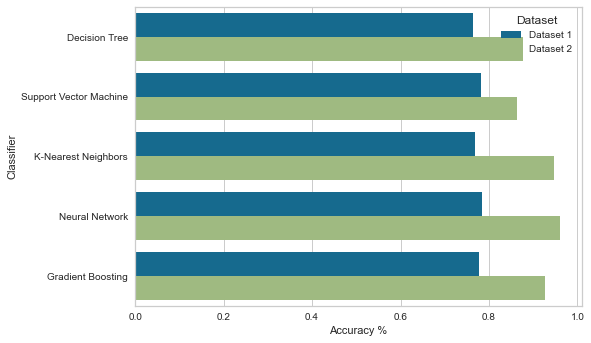

In [28]:
sns.barplot(data=df_accuracy, y="Classifier", x="Accuracy %", hue="Dataset")

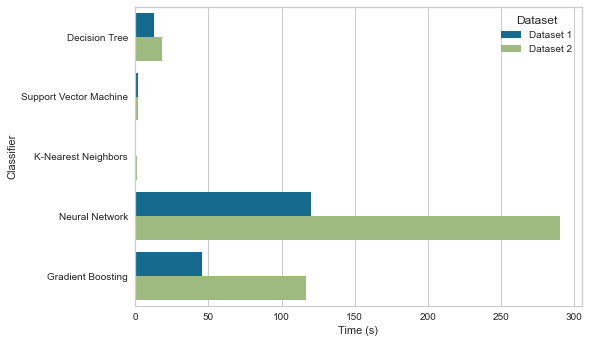

In [29]:
sns.barplot(data=df_train_time, y="Classifier", x="Time (s)", hue="Dataset")

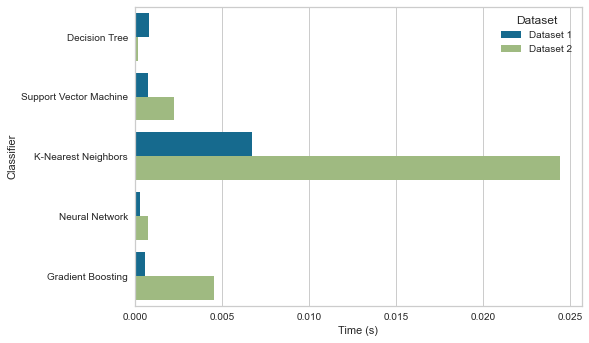

In [30]:
sns.barplot(data=df_test_time, y="Classifier", x="Time (s)", hue="Dataset")